In this notebook, I've adapted the code from the YouTube video [Running the Double-Slit Experiment on a Quantum Computer](https://youtu.be/PBrYoAdLzXo?si=1GKFmKGxF7wgDTPC) to run on the new IBM Quantum platform (At date Oct-2025).

Additionally, I modified the approach. Instead of running a single-qubit circuit multiple times to simulate one point on the screen, this version runs a multi-qubit circuit where each qubit represents a single point. With this adaptation, a circuit simulating 100 points on the screen (using 100 qubits) takes approximately 2 seconds to execute on a quantum processor.

In [ ]:
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

π = np.pi # Convert π to a numerical value

A qubit in this circuit only simulates the behavior of a point $y$ on the screen. Therefore, I discretize the screen where the probability of a photon hitting each point on the screen will be simulated by a circuit line with a specific $\alpha$.

In [6]:
def circuit_doubleSlit(qubits):
    
    φ_scrn = 6*np.pi #Length of the screen in some strange units
    φ_lst = np.linspace(-φ_scrn/2,φ_scrn/2,qubits) # Discretization of the screen
    qc = QuantumCircuit(qubits) # Create a quantum circuit with 'lines' qubits

    for i in range(qubits):
        qc.h(i) # Apply Hadamard gate to each qubit
        qc.p(φ_lst[i],i) # Apply phase shift to each qubit
        qc.h(i) # Apply Hadamard gate again to each qubit

    # Measure all qubits

    qc.measure_all()
    return qc, φ_lst

In [ ]:
# Initialize the Qiskit Runtime Service with your credentials
service = QiskitRuntimeService(channel="ibm_quantum_platform", instance = "[YOUR_IBM_INSTANCE_HERE]", token = "[YOUR_IBM_KEY_HERE]")

In [26]:
# Get the least busy backend that is operational and not a simulator
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

For the quantum simulation, we used 100 circuit lines to discretize the screen. The circuit is run $2^{9}$ times to reconstruct the probabilities. 

In [27]:
shots = 2**9 # Number of shots for the quantum execution
qubits = 100 # Number of qubits for the double slit circuit
double_Slit, φ_lst = circuit_doubleSlit(qubits) # Create the double slit circuit with 100 qubits
pm = generate_preset_pass_manager(backend=backend, optimization_level=1) # Transpile the circuit for the backend
circuit_opt = pm.run(double_Slit)   

In [28]:
#Execute using the Sampler primitive
sampler = Sampler(mode=backend)
sampler.options.default_shots = shots  # Options can be set using auto-complete.
job = sampler.run([circuit_opt]) # Run the circuit on the backend
print(f"Job ID is {job.job_id()}") # Get the job ID
pub_result = job.result()[0] # Get the result of the job

Job ID is d2e8utfl2k0s73ai4tu0


In [29]:
# Initialize a list to store all positions of zeros
all_zero_positions = []


# Iterate over each key in the dictionary
for key in pub_result.data.meas.get_counts().keys():
    # Find all indices of '0' in the key string
    positions = [i  for i, char in enumerate(key) if char == '0']
    # Extend the main list with the positions found in the current key
    all_zero_positions.extend(positions)

φ_events = [φ_lst[i] for i in all_zero_positions]


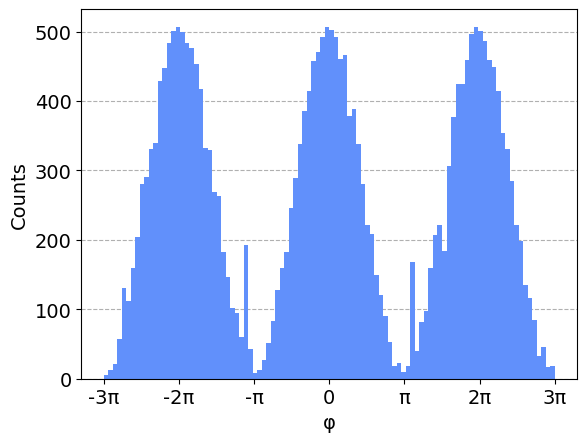

In [ ]:
# Plot the histogram of hits in the screen at specific φ values
ax = plt.subplot()
plt.hist(φ_events, bins=qubits, color='#6190fb')
plt.xticks(ticks=[-3*π, -2*π, -π, 0, π, 2*π, 3*π],
           labels=['-3π','-2π','-π','0','π','2π','3π'],
           fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'φ$\left(\frac{2 \pi s}{\lambda d}y\right)$', fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.grid(axis='y',linestyle='dashed')
ax.set_axisbelow(True)
plt.show()

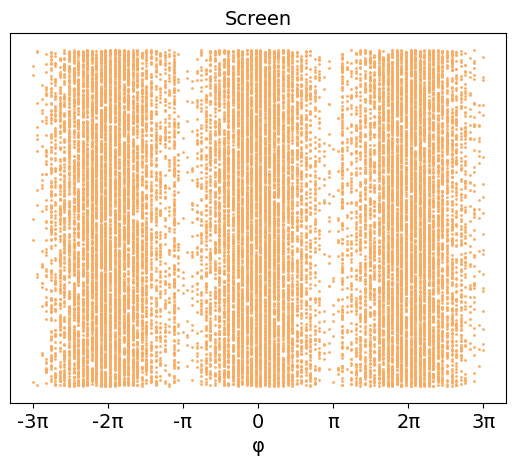

In [ ]:
# Emulate hits on a screen. Values of z coordinate are selected at random

z_hit = np.random.uniform(-1,1,len(φ_events)) # Random z coordinates for the hits

plt.scatter(φ_events,z_hit, s = 1, color="#fbab61")
plt.tick_params(axis='both', left=False, labelleft=False)
plt.xticks(ticks=[-3*π, -2*π, -π, 0, π, 2*π, 3*π],
           labels=['-3π','-2π','-π','0','π','2π','3π'],
           fontsize=14)
plt.xlabel(r'φ$\left(\frac{2 \pi s}{\lambda d}y\right)$', fontsize=14)
plt.title('Screen', fontsize=14)
plt.show()

I recovered the same behavior obtained on [Running the Double-Slit Experiment on a Quantum Computer](https://youtu.be/PBrYoAdLzXo?si=1GKFmKGxF7wgDTPC).